# 🏎️ F1 Live Lap Time Prediction - Multi-Year Model (2022-2023)

## Project Overview

**Goal**: Build a machine learning model to predict F1 lap times in real-time during a race

**Key Innovation**: Rolling window approach that simulates live race conditions
- Uses only the **last 3-5 laps** to predict the next lap
- Mimics real-time decision making (no future data leakage)
- Can inform pit stop strategy, tire management, and race tactics

**Dataset Enhancement**: 
- **2022 Season**: ~23,000 laps from 22 Grand Prix races
- **2023 Season**: ~24,000 laps from 22 Grand Prix races
- **Total**: ~47,000 laps across 44 races over 2 seasons

**Why Multi-Year?**
- More training examples → Better generalization
- More diverse race conditions (weather, tire strategies, incidents)
- Robust to cross-season variations
- Trade-off: 2022 had new regulations (ground effect cars) but rolling window approach minimizes impact

## 1. Setup and Data Loading

In [3]:
import pandas as pd
import numpy as np
import os, joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Try Except for XGBoost (Because not working in mac)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
    print('✅ XGBoost imported successfully!')
except Exception as e:
    XGBOOST_AVAILABLE = False
    print(f'⚠️  XGBoost not available: {str(e)[:100]}...')
    print('   Continuing with RandomForest and GradientBoosting only')

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)

print('\n✅ Imports complete!')

✅ XGBoost imported successfully!

✅ Imports complete!


### 1.1 Load and Combine Multi-Year Data

In [4]:
# Load 2023 data
df_2023 = pd.read_csv('data/f1_ml_laps_dataset.csv')
print(f"📊 2023 Data: {len(df_2023):,} laps")

# Load 2022 data
df_2022 = pd.read_csv('data/f1_2022_races.csv')
print(f"📊 2022 Data: {len(df_2022):,} laps (raw)")

# Fix season column in 2022 data (has NA values)
df_2022['season'] = df_2022['season'].fillna(2022).astype(int)
df_2023['season'] = df_2023['season'].astype(int)

# Combining both seasons
df = pd.concat([df_2022, df_2023], ignore_index=True)

# Clean & sort
df = df.sort_values(['season', 'gp_name', 'driver', 'lap_number']).reset_index(drop=True)
df['lap_time'] = df['lap_time'].astype(float)

print(f"\n Combined Dataset:")
print(f"   Total laps: {len(df):,}")
print(f"   2022 laps: {len(df[df['season']==2022]):,}")
print(f"   2023 laps: {len(df[df['season']==2023]):,}")
print(f"\n   Races per season:")
for season in sorted(df['season'].unique()):
    n_races = df[df['season']==season]['gp_name'].nunique()
    print(f"     {season}: {n_races} Grand Prix races")

print(f"\n Sample data:")
df.head()

📊 2023 Data: 23,983 laps
📊 2022 Data: 23,050 laps (raw)

 Combined Dataset:
   Total laps: 47,033
   2022 laps: 23,050
   2023 laps: 23,983

   Races per season:
     2022: 22 Grand Prix races
     2023: 22 Grand Prix races

 Sample data:


,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,sector_3_time,position,track_status,is_pit_lap,compound,stint,tyre_life,fresh_tyre,speed_mean,speed_max,throttle_mean,brake_mean,rpm_mean,rpm_max,drs_activations,air_temp,track_temp,humidity,wind_speed,wind_dir,pressure
0,2022,Abu Dhabi Grand Prix,Race,Race,ALB,Williams,1,101.738,NaN,40.201,36.214,17,1,False,MEDIUM,1,1.0,True,184.243243,330,54.132432,0.243243,9903.794595,12184,370,28.7,34.7,62,3.5,311,1013.4
1,2022,Abu Dhabi Grand Prix,Race,Race,ALB,Williams,2,93.227,18.788,39.586,34.853,16,1,False,MEDIUM,1,2.0,True,199.156805,324,60.343195,0.236686,10100.500000,11911,337,28.7,34.9,61,2.7,319,1013.5
2,2022,Abu Dhabi Grand Prix,Race,Race,ALB,Williams,3,92.356,18.723,38.407,35.226,16,1,False,MEDIUM,1,3.0,True,205.739766,331,62.359649,0.190058,10170.763160,12385,103,28.6,34.4,62,3.0,328,1013.5
3,2022,Abu Dhabi Grand Prix,Race,Race,ALB,Williams,4,93.137,18.687,38.424,36.026,16,1,False,MEDIUM,1,4.0,True,201.869436,334,61.115727,0.204748,10154.545990,12333,102,28.7,34.3,63,2.5,334,1013.5
4,2022,Abu Dhabi Grand Prix,Race,Race,ALB,Williams,5,92.652,18.785,38.870,34.997,15,1,False,MEDIUM,1,5.0,True,202.713881,339,60.810198,0.232295,10150.861190,12508,105,28.6,34.0,62,2.9,341,1013.5


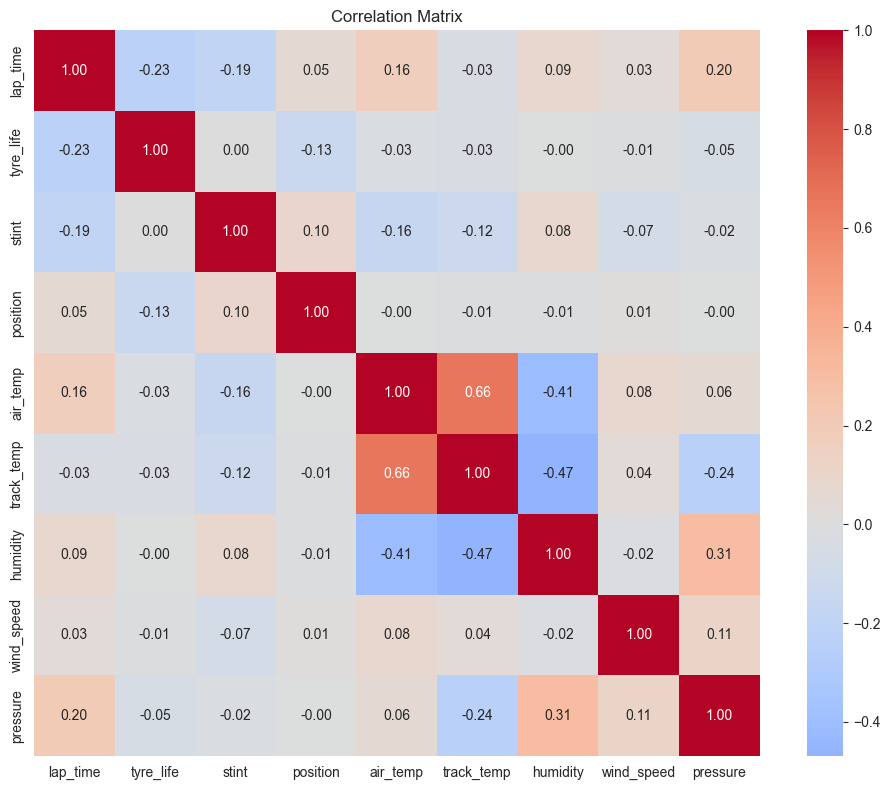

In [5]:
# Correlation heatmap
numeric_cols = ['lap_time', 'tyre_life', 'stint', 'position', 'air_temp', 'track_temp', 'humidity', 'wind_speed', 'pressure']
numeric_cols = [c for c in numeric_cols if c in df.columns]

plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

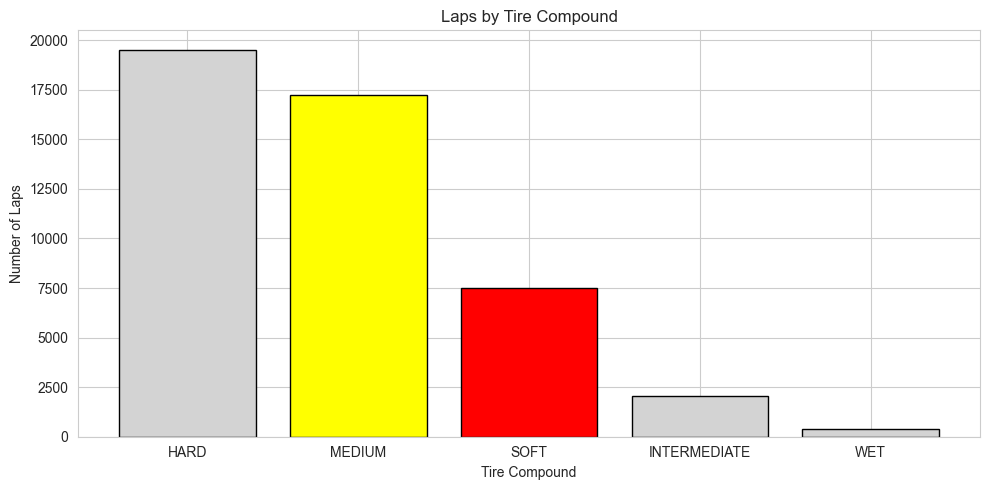

Laps per compound:
compound
HARD            19522
MEDIUM          17257
SOFT             7506
INTERMEDIATE     2048
WET               367
Name: count, dtype: int64


In [6]:
# Tire compound distribution
plt.figure(figsize=(10, 5))
compound_counts = df['compound'].value_counts()
colors = ['red' if c == 'SOFT' else 'yellow' if c == 'MEDIUM' else 'lightgray' for c in compound_counts.index]
plt.bar(compound_counts.index, compound_counts.values, color=colors, edgecolor='black')
plt.xlabel('Tire Compound')
plt.ylabel('Number of Laps')
plt.title('Laps by Tire Compound')
plt.tight_layout()
plt.show()

print("Laps per compound:")
print(compound_counts)

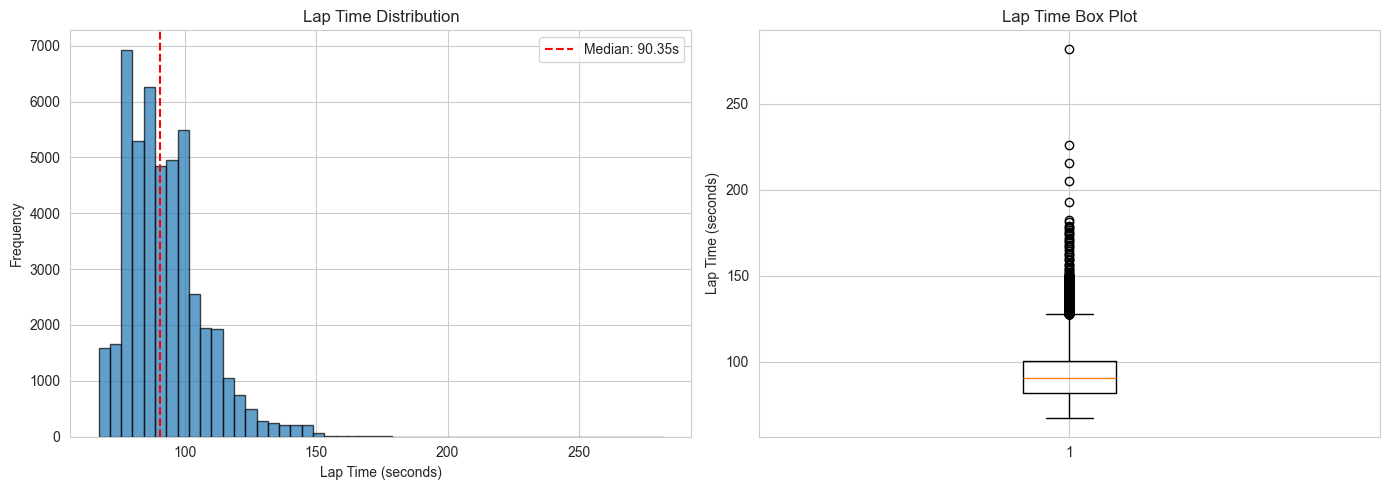

Lap time stats:
count    47033.000000
mean        92.361275
std         14.660837
min         67.012000
25%         81.792000
50%         90.350000
75%        100.090000
max        282.084000
Name: lap_time, dtype: float64


In [7]:
# Lap time distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['lap_time'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Lap Time (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Lap Time Distribution')
axes[0].axvline(df['lap_time'].median(), color='red', linestyle='--', label=f"Median: {df['lap_time'].median():.2f}s")
axes[0].legend()

axes[1].boxplot(df['lap_time'].dropna())
axes[1].set_ylabel('Lap Time (seconds)')
axes[1].set_title('Lap Time Box Plot')

plt.tight_layout()
plt.show()

print("Lap time stats:")
print(df['lap_time'].describe())

Missing values:
               Missing   Percent
sector_1_time      860  1.828503
tyre_life          508  1.080093
compound           333  0.708014
sector_2_time        2  0.004252
sector_3_time        1  0.002126


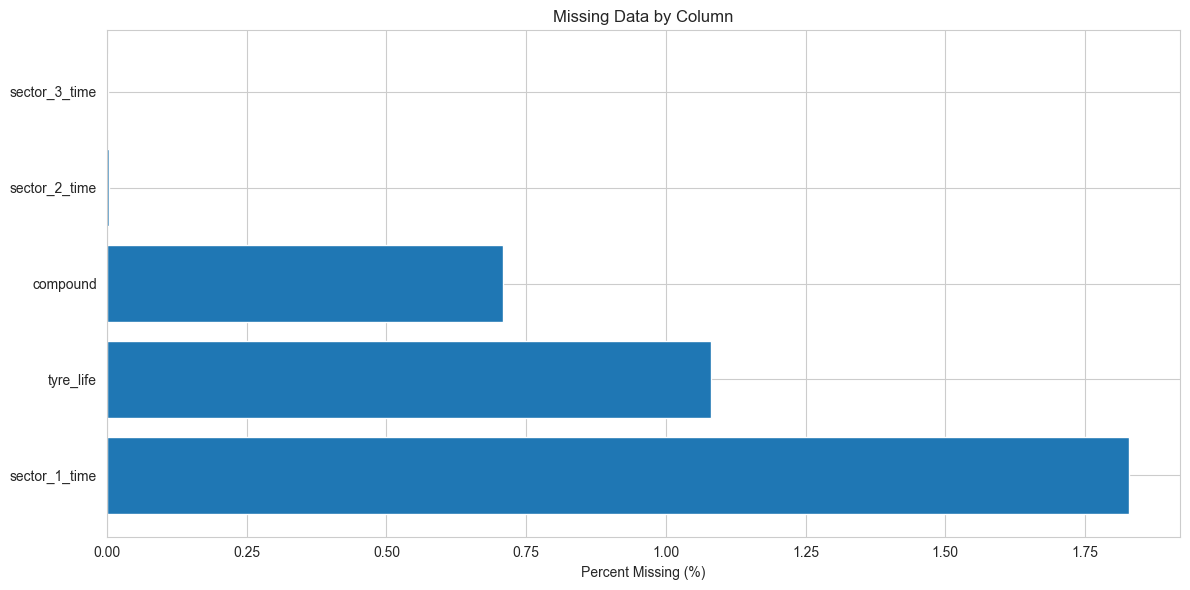

In [8]:
# Checking for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct}).sort_values('Missing', ascending=False)

print("Missing values:")
print(missing_df[missing_df['Missing'] > 0].head(15))

plt.figure(figsize=(12, 6))
top_missing = missing_df[missing_df['Missing'] > 0].head(15)
if len(top_missing) > 0:
    plt.barh(range(len(top_missing)), top_missing['Percent'])
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Percent Missing (%)')
    plt.title('Missing Data by Column')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values!")

## 1.5 Exploratory Data Analysis

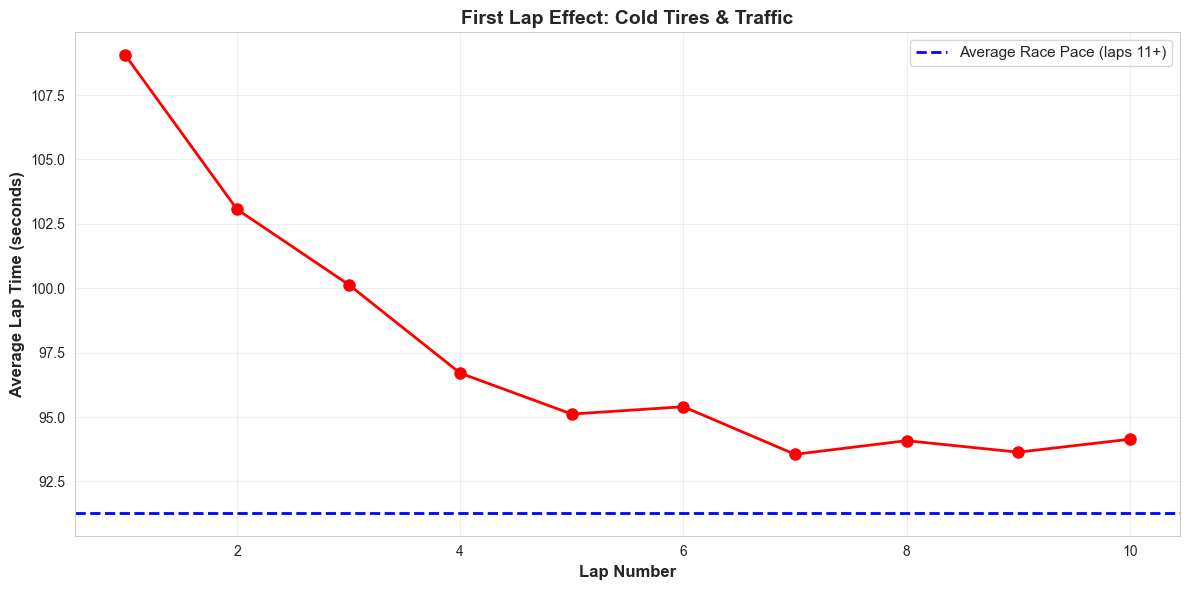

Lap 1 average: 109.05s
Lap 5 average: 95.12s
Race pace (lap 11+): 91.28s
Difference: 17.76s slower on lap 1


In [9]:
# First lap analysis
first_10_laps = df[df['lap_number'] <= 10].copy()

avg_by_lap = first_10_laps.groupby('lap_number')['lap_time'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_by_lap.index, avg_by_lap.values, marker='o', linewidth=2, markersize=8, color='red')
plt.axhline(df[df['lap_number'] > 10]['lap_time'].mean(), 
            color='blue', linestyle='--', linewidth=2, label='Average Race Pace (laps 11+)')
plt.xlabel('Lap Number', fontsize=12, fontweight='bold')
plt.ylabel('Average Lap Time (seconds)', fontsize=12, fontweight='bold')
plt.title('First Lap Effect: Cold Tires & Traffic', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Lap 1 average: {avg_by_lap[1]:.2f}s")
print(f"Lap 5 average: {avg_by_lap[5]:.2f}s")
print(f"Race pace (lap 11+): {df[df['lap_number'] > 10]['lap_time'].mean():.2f}s")
print(f"Difference: {avg_by_lap[1] - df[df['lap_number'] > 10]['lap_time'].mean():.2f}s slower on lap 1")


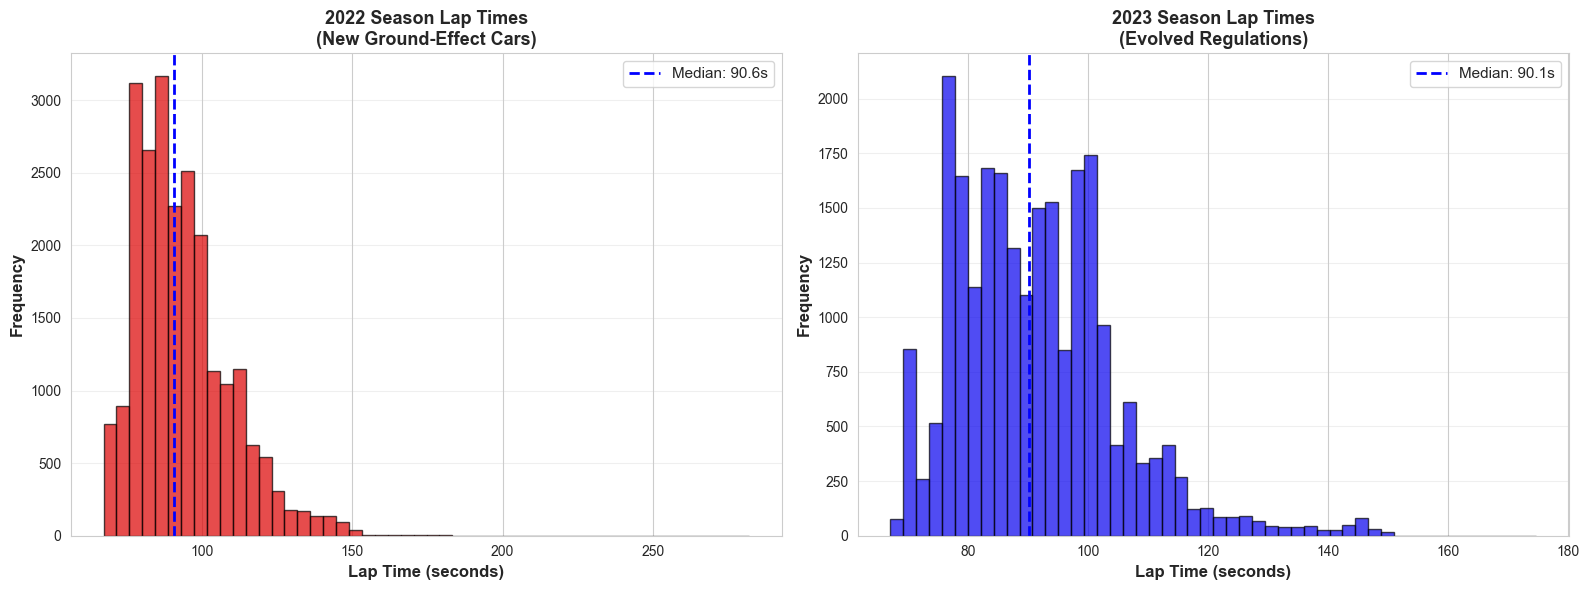

2022 Season Stats:
  Median: 90.61s

2023 Season Stats:
  Median: 90.07s

Difference:
  Median: 0.55s


In [10]:
# Comparing lap time distributions between seasons
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2022 Distribution
axes[0].hist(df[df['season']==2022]['lap_time'].dropna(), bins=50, 
             color='#dc0000', alpha=0.7, edgecolor='black')
axes[0].axvline(df[df['season']==2022]['lap_time'].median(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f"Median: {df[df['season']==2022]['lap_time'].median():.1f}s")
axes[0].set_xlabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('2022 Season Lap Times\n(New Ground-Effect Cars)', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# 2023 Distribution
axes[1].hist(df[df['season']==2023]['lap_time'].dropna(), bins=50, 
             color='#0600ef', alpha=0.7, edgecolor='black')
axes[1].axvline(df[df['season']==2023]['lap_time'].median(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f"Median: {df[df['season']==2023]['lap_time'].median():.1f}s")
axes[1].set_xlabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('2023 Season Lap Times\n(Evolved Regulations)', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('season_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats comparison
print(f"2022 Season Stats:")
print(f"  Median: {df[df['season']==2022]['lap_time'].median():.2f}s")

print(f"\n2023 Season Stats:")
print(f"  Median: {df[df['season']==2023]['lap_time'].median():.2f}s")

print(f"\nDifference:")
print(f"  Median: {abs(df[df['season']==2022]['lap_time'].median() - df[df['season']==2023]['lap_time'].median()):.2f}s")

## 2. Feature Engineering: Rolling Window Approach

### 🎯 Key Concept: "Live" Prediction

In a real F1 race, teams can only use **past lap data** to predict the next lap. We simulate this by:

1. **Lag Features**: Previous 3 lap times (what just happened)
2. **Rolling Averages**: Recent performance trends (last 3-5 laps)
3. **Current Conditions**: Tire age, weather, position

**Example**: To predict Lap 20, we use:
- ✅ Laps 17, 18, 19 (past data)
- ✅ Tire age, weather at Lap 19
- ❌ NO data from Lap 20 or beyond

**Multi-Year Benefit**: By including 2022 data, the model learns degradation patterns from ~47,000 laps instead of ~24,000!

This ensures **zero data leakage** and mimics real-time race strategy!

In [11]:
group = ['gp_name', 'driver', 'season']  # Added season to grouping

# LAG FEATURES: Previous lap times (what just happened)
df["prev_lap_time"]  = df.groupby(group)["lap_time"].shift(1)
df["prev2_lap_time"] = df.groupby(group)["lap_time"].shift(2)
df["prev3_lap_time"] = df.groupby(group)["lap_time"].shift(3)

# ROLLING FEATURES: Recent trends
df["rolling_mean_3"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).mean())
df["rolling_mean_5"] = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(5, min_periods=1).mean())
df["rolling_std_3"]  = df.groupby(group)["lap_time"].transform(lambda x: x.rolling(3, min_periods=1).std())

# WEATHER CHANGES: Track evolution
weather_cols = ['air_temp','track_temp','humidity','wind_speed','pressure','wind_dir']
for col in [c for c in weather_cols if c in df.columns]:
    df[f"{col}_change"] = df.groupby(group)[col].transform(lambda x: x.diff())

# TARGET: Next lap time (what we're predicting)
df["target_next_lap"] = df.groupby(group)["lap_time"].shift(-1)

# Clean dataset (remove rows without enough history)
df_model = df.dropna(subset=[
    "target_next_lap","prev_lap_time","prev2_lap_time","prev3_lap_time"
]).copy()

print(f"✅ Features created!")
print(f"   Clean dataset: {len(df_model):,} laps")
print(f"   2022: {len(df_model[df_model['season']==2022]):,} laps")
print(f"   2023: {len(df_model[df_model['season']==2023]):,} laps")
#print(f"\n📊 Example: How we predict Lap 20")
#example = df_model[df_model['lap_number'] == 20].iloc[0]
#print(f"   Season: {int(example['season'])}")
#print(f"   Current lap: {example['lap_number']}")
#print(f"   Previous laps used: {example['prev_lap_time']:.2f}s, {example['prev2_lap_time']:.2f}s, {example['prev3_lap_time']:.2f}s")
#print(f"   Rolling mean (last 3): {example['rolling_mean_3']:.2f}s")
#print(f"   Tire age: {example['tyre_life']} laps")
#print(f"   → Predict next lap: {example['target_next_lap']:.2f}s")

✅ Features created!
   Clean dataset: 43,616 laps
   2022: 21,343 laps
   2023: 22,273 laps


## 3. Feature Selection

In [12]:
# Numeric features
numeric_features = [c for c in [
    'lap_number',  # Race progression
    'prev_lap_time', 'prev2_lap_time', 'prev3_lap_time',  # Recent performance
    'rolling_mean_3', 'rolling_mean_5', 'rolling_std_3',  # Trends
    'tyre_life', 'stint', 'fresh_tyre',  # Tire state
    'is_pit_lap', 'position',  # Race context
    'air_temp', 'track_temp', 'humidity', 'wind_speed', 'pressure', 'wind_dir'  # Weather
] if c in df_model.columns]

# Add weather change features
numeric_features += [c for c in df_model.columns if c.endswith('_change')]

# Categorical features (removed gp_name for generalizability)
categorical_features = [c for c in ['driver', 'team', 'compound', 'track_status'] 
                        if c in df_model.columns]

feature_cols = numeric_features + categorical_features

print(f"📊 Total features: {len(feature_cols)}")
print(f"   - Numeric: {len(numeric_features)}")
print(f"   - Categorical: {len(categorical_features)}")

📊 Total features: 28
   - Numeric: 24
   - Categorical: 4


In [13]:

# Feature matrix and target
X_full = df_model[feature_cols].copy()
y_full = df_model['target_next_lap'].copy()

print("🔍 Checking for NaN values in feature matrix (before cleaning)...")
nan_counts = X_full.isnull().sum()
nan_features = nan_counts[nan_counts > 0]

if len(nan_features) > 0:
    print(f"   Found NaN values in {len(nan_features)} features:")
    for feat, count in nan_features.items():
        print(f"     {feat}: {count} NaNs")

    print("\n   📌 Handling NaNs:")
    # Numeric columns → fill with median
    numeric_cols = X_full.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X_full[col].isnull().any():
            median_val = X_full[col].median()
            X_full[col].fillna(median_val, inplace=True)
            print(f"     [NUM] {col}: filled with median = {median_val:.4f}")

    # Categorical columns → fill with mode (or 'UNKNOWN' fallback)
    categorical_cols = X_full.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if X_full[col].isnull().any():
            mode_vals = X_full[col].mode()
            fill_val = mode_vals[0] if len(mode_vals) > 0 else 'UNKNOWN'
            X_full[col].fillna(fill_val, inplace=True)
            print(f"     [CAT] {col}: filled with mode = {fill_val}")

    # Sanity check
    if X_full.isnull().any().any():
        print("\n⚠️  Still found NaNs after cleaning!")
    else:
        print("\n✅ All NaN values handled. Feature matrix is clean.")
else:
    print("   ✅ No NaN values found in features!")


🔍 Checking for NaN values in feature matrix (before cleaning)...
   Found NaN values in 2 features:
     tyre_life: 491 NaNs
     compound: 320 NaNs

   📌 Handling NaNs:
     [NUM] tyre_life: filled with median = 13.0000
     [CAT] compound: filled with mode = HARD

✅ All NaN values handled. Feature matrix is clean.


C:\Users\shrey\AppData\Local\Temp\ipykernel_51184\3748907062.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_full[col].fillna(median_val, inplace=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_51184\3748907062.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

## 4. Train/Test Split: Temporal Hold-Out Validation

**Validation Strategy**: 
- **Train**: 2022 full season (22 races) + 2023 races (21 races) = **43 races, ~40,000 laps**
- **Test**: United States Grand Prix 2023 (1 race, ~1,000 laps)

**Why this works:**
- Temporal validation: Testing on a 2023 race
- Multi-year training: Model learns from 2 seasons of data
- No data leakage: Entire test race held out
- Realistic: Simulates predicting a new race using historical patterns

In [14]:
test_gp = 'United States Grand Prix'
test_season = 2023

print(f'🏁 Test GP: {test_gp} ({test_season})')

# Mask for US GP 2023 as test set
mask = (df_model['gp_name'] == test_gp) & (df_model['season'] == test_season)

# Split using the already-cleaned X_full / y_full
X_train_raw = X_full[~mask].copy()
X_test_raw  = X_full[mask].copy()
y_train = y_full[~mask].copy()
y_test  = y_full[mask].copy()

# One-hot encode categorical features
X_train = pd.get_dummies(X_train_raw, columns=categorical_features, drop_first=True)
X_test  = pd.get_dummies(X_test_raw,  columns=categorical_features, drop_first=True)

# Align columns: ensure X_test has same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Making sure there are no NaNs after encoding
if X_train.isnull().any().any():
    print('\n⚠️  Found NaNs in X_train after encoding. Filling with 0...')
    X_train.fillna(0, inplace=True)

if X_test.isnull().any().any():
    print('⚠️  Found NaNs in X_test after encoding. Filling with 0...')
    X_test.fillna(0, inplace=True)

feature_columns = X_train.columns.tolist()

# Train split breakdown by season
train_2022 = df_model[~mask & (df_model['season'] == 2022)]
train_2023 = df_model[~mask & (df_model['season'] == 2023)]

print('\n📊 Data split:')
print(f'   Train (2022):  {len(train_2022):,} laps from {train_2022["gp_name"].nunique()} races')
print(f'   Train (2023):  {len(train_2023):,} laps from {train_2023["gp_name"].nunique()} races')
print(f'   Train (Total): {len(X_train):,} laps from 2 seasons')
print(f'   Test (2023):   {len(X_test):,} laps from {test_gp}')
print(f'   Features after encoding: {len(feature_columns)}')


🏁 Test GP: United States Grand Prix (2023)

📊 Data split:
   Train (2022):  21,343 laps from 22 races
   Train (2023):  21,339 laps from 21 races
   Train (Total): 42,682 laps from 2 seasons
   Test (2023):   934 laps from United States Grand Prix
   Features after encoding: 91


In [15]:
print("\n🔎 Feature Breakdown After One-Hot Encoding")
print("-------------------------------------------")

total_features = len(X_train.columns)
num_numeric = len(numeric_features)
num_dummy = total_features - num_numeric

print(f"Total features used for training: {total_features}")
print(f"Numeric features: {num_numeric}")
print(f"Dummy (one-hot) features: {num_dummy}")

# Breakdown per categorical variable
print("\nDummy columns per categorical feature:")
for cat in categorical_features:
    encoded_cols = [c for c in X_train.columns if c.startswith(cat + "_")]
    print(f"  {cat}: {len(encoded_cols)} columns")



🔎 Feature Breakdown After One-Hot Encoding
-------------------------------------------
Total features used for training: 91
Numeric features: 24
Dummy (one-hot) features: 67

Dummy columns per categorical feature:
  driver: 24 columns
  team: 9 columns
  compound: 4 columns
  track_status: 30 columns


## 5. Model Training & Comparison

In [16]:
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=400, max_depth=12, n_jobs=-1, random_state=42
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=400, max_depth=10, learning_rate=0.05, 
        subsample=0.9, random_state=42
    )
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.05, 
        subsample=0.9, random_state=42, verbosity=0
    )
    print('✅ XGBoost added to model comparison')

print('='*70)
print('TRAINING MODELS (Multi-Year: 2022 + 2023)')
print('='*70)

results = []
trained_models = {}

for name, model in models.items():
    print(f'\n{name}:')
    
    # Train
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    
    # Cross-validation on training set
    print('  Running 5-fold CV...')
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                 scoring='r2', n_jobs=-1)
    cv_r2_mean = cv_scores.mean()
    cv_r2_std = cv_scores.std()
    
    results.append([name, r2, mae, rmse, mape, cv_r2_mean, cv_r2_std])
    trained_models[name] = {'model': model, 'predictions': pred}
    
    print(f'  Test R²:  {r2:.4f}')
    print(f'  MAE:      {mae:.4f}s')
    print(f'  MAPE:     {mape:.2f}%')
    print(f'  CV R²:    {cv_r2_mean:.4f} (+/- {cv_r2_std:.4f})')

results_df = pd.DataFrame(results, 
                          columns=['Model','R2','MAE','RMSE','MAPE','CV_R2_Mean','CV_R2_Std'])

print('\n' + '='*70)
print('RESULTS SUMMARY (Trained on 2022 + 2023 Data)')
print('='*70)
results_df

✅ XGBoost added to model comparison


TRAINING MODELS (Multi-Year: 2022 + 2023)

RandomForest:
  Running 5-fold CV...
  Test R²:  0.8556
  MAE:      0.9488s
  MAPE:     0.91%
  CV R²:    0.7782 (+/- 0.0333)

GradientBoosting:
  Running 5-fold CV...
  Test R²:  0.8461
  MAE:      0.8690s
  MAPE:     0.83%
  CV R²:    0.7793 (+/- 0.0406)

XGBoost:
  Running 5-fold CV...
  Test R²:  0.8987
  MAE:      0.7447s
  MAPE:     0.71%
  CV R²:    0.7945 (+/- 0.0295)

RESULTS SUMMARY (Trained on 2022 + 2023 Data)


,Model,R2,MAE,RMSE,MAPE,CV_R2_Mean,CV_R2_Std
0,RandomForest,0.855566,0.948793,1.586721,0.906835,0.778170,0.033345
1,GradientBoosting,0.846050,0.869047,1.638158,0.829057,0.779278,0.040566
2,XGBoost,0.898715,0.744665,1.328736,0.711412,0.794549,0.029490


In [17]:
# Select best model
best_row = results_df.sort_values('R2', ascending=False).iloc[0]
best_model_name = best_row['Model']
best_model = trained_models[best_model_name]['model']
y_pred = trained_models[best_model_name]['predictions']

print('='*70)
print(f'🏆 BEST MODEL: {best_model_name}')
print('='*70)
print(f'Training data: 2022 + 2023 (~{len(X_train):,} laps)')
print(f'Test data:     {test_gp} {test_season} ({len(X_test):,} laps)')
print(f'\nPerformance:')
print(f'  Test R²:     {best_row["R2"]:.6f}')
print(f'  MAE:         {best_row["MAE"]:.4f} seconds')
print(f'  MAPE:        {best_row["MAPE"]:.2f}%')
print('='*70)
print(f'\n💡 Interpretation:')
print(f'   - R² = {best_row["R2"]:.3f} means model explains {best_row["R2"]*100:.1f}% of variance')
print(f'   - MAE = {best_row["MAE"]:.2f}s means average error is {best_row["MAE"]:.2f} seconds per lap')
print(f'   - MAPE = {best_row["MAPE"]:.2f}% means {best_row["MAPE"]:.1f}% error relative to actual lap time')


🏆 BEST MODEL: XGBoost
Training data: 2022 + 2023 (~42,682 laps)
Test data:     United States Grand Prix 2023 (934 laps)

Performance:
  Test R²:     0.898715
  MAE:         0.7447 seconds
  MAPE:        0.71%

💡 Interpretation:
   - R² = 0.899 means model explains 89.9% of variance
   - MAE = 0.74s means average error is 0.74 seconds per lap
   - MAPE = 0.71% means 0.7% error relative to actual lap time


## 6. Model Visualizations

### 6.1 Actual vs Predicted: Overall Performance

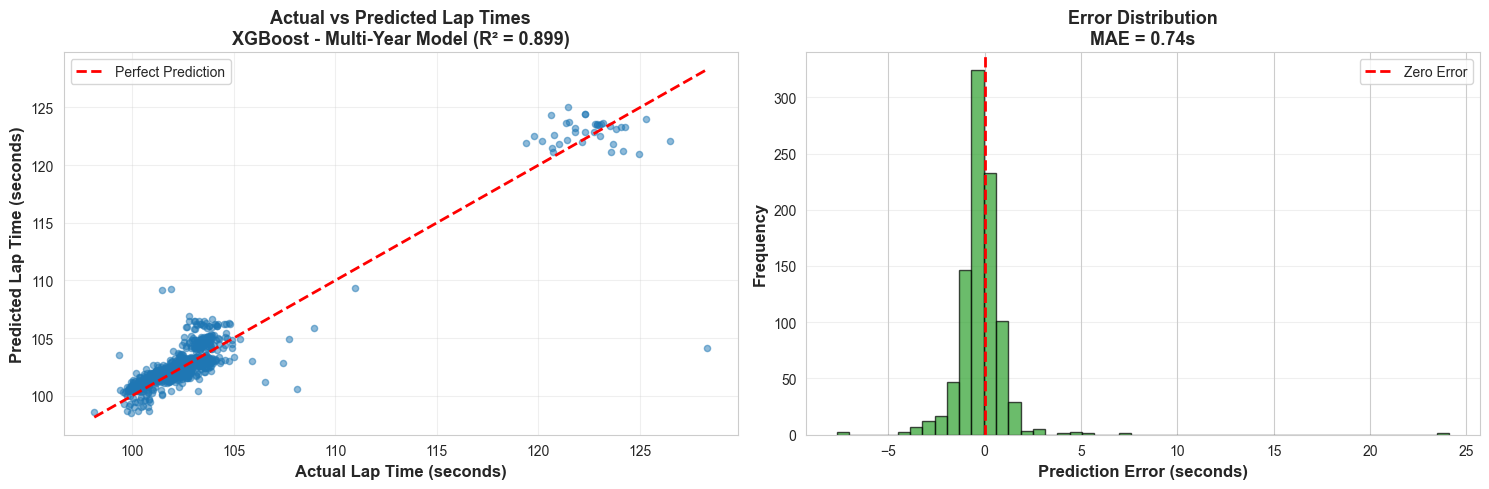

📊 Error Statistics:
   Mean error: -0.201s
   Std error:  1.314s


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Actual vs Predicted
ax1.scatter(y_test, y_pred, alpha=0.5, s=20, color='#1f77b4')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Lap Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Lap Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title(f'Actual vs Predicted Lap Times\n{best_model_name} - Multi-Year Model (R² = {best_row["R2"]:.3f})', 
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error distribution
errors = y_test - y_pred
ax2.hist(errors, bins=50, color='#2ca02c', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Prediction Error (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title(f'Error Distribution\nMAE = {best_row["MAE"]:.2f}s', 
              fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output_actual_vs_predicted_multiyear.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Error Statistics:")
print(f"   Mean error: {errors.mean():.3f}s")
print(f"   Std error:  {errors.std():.3f}s")

### 6.2 Feature Importance

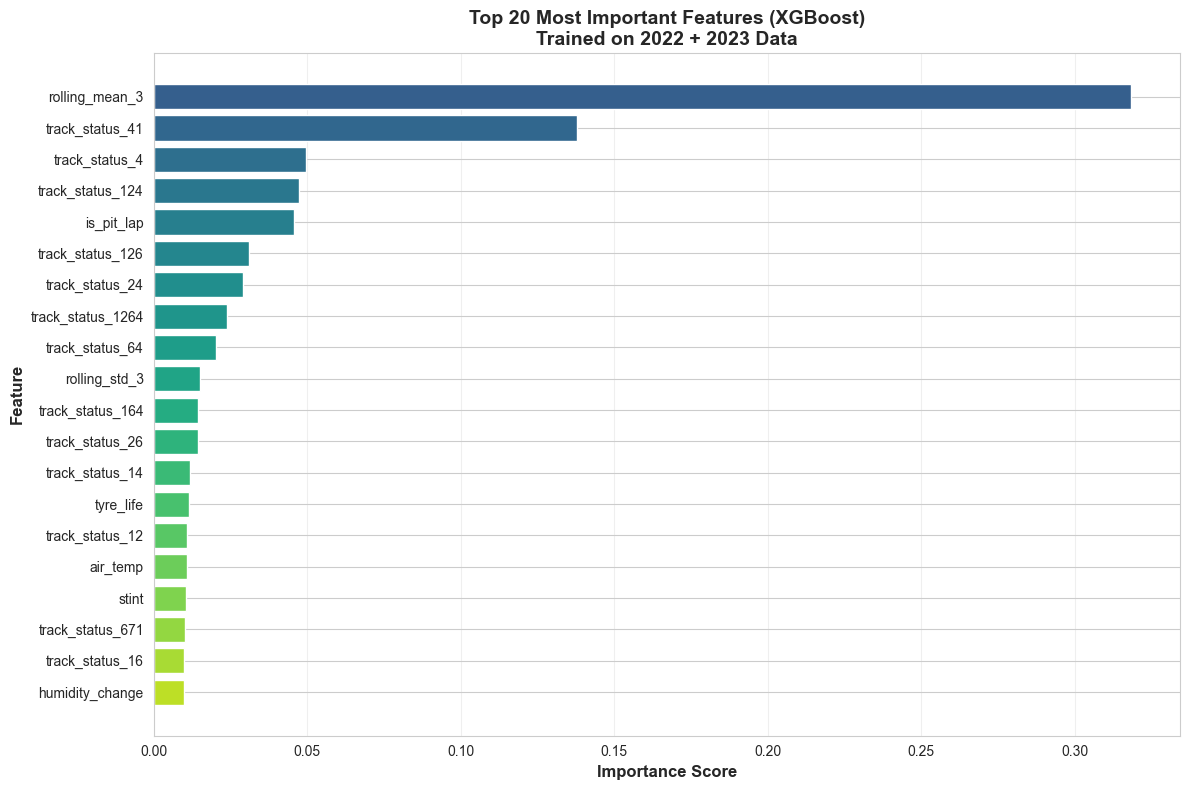


📊 Top 10 Features:
   rolling_mean_3                 0.3184
   track_status_41                0.1379
   track_status_4                 0.0495
   track_status_124               0.0474
   is_pit_lap                     0.0458
   track_status_126               0.0312
   track_status_24                0.0292
   track_status_1264              0.0239
   track_status_64                0.0203
   rolling_std_3                  0.0151


In [19]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    # DataFrame
    feat_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(20)
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feat_imp_df)))
    bars = plt.barh(range(len(feat_imp_df)), feat_imp_df['importance'], color=colors)
    plt.yticks(range(len(feat_imp_df)), feat_imp_df['feature'])
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top 20 Most Important Features ({best_model_name})\nTrained on 2022 + 2023 Data', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('output_feature_importance_multiyear.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 10 Features:")
    for idx, row in feat_imp_df.head(10).iterrows():
        print(f"   {row['feature']:30s} {row['importance']:.4f}")
else:
    print("⚠️  Feature importances not available for this model type")

## 7. Live Race Simulation: Lap-by-Lap Prediction

### 🎯 Demonstrating "Live" Prediction

This section simulates how the model would work during an actual race:
- We predict each lap using **only past data available at that moment**
- No future information is used (zero data leakage)
- Shows real-time prediction accuracy throughout the race
- Model trained on 2 seasons (~47,000 laps) for robust predictions!

In [20]:
# Selecting a driver for live simulation
test_data = df_model[(df_model['gp_name'] == test_gp) & (df_model['season'] == test_season)].copy()
driver = 'VER'  # Verstappen
driver_data = test_data[test_data['driver'] == driver].sort_values('lap_number')

print(f"Live Race Simulation: {driver} at {test_gp} {test_season}")
print(f"   Model trained on: 2022 + 2023 data (~{len(X_train):,} laps)")
print(f"   Total laps in simulation: {len(driver_data)}")
print(f"\n   Simulating lap-by-lap predictions...\n")

# Predictions for this driver
driver_indices = driver_data.index
driver_actual = y_test.loc[driver_indices]
driver_pred = pd.Series(y_pred, index=y_test.index).loc[driver_indices]

# Results DataFrame
live_sim = pd.DataFrame({
    'lap_number': driver_data['lap_number'].values,
    'actual': driver_actual.values,
    'predicted': driver_pred.values,
    'error': driver_actual.values - driver_pred.values,
    'compound': driver_data['compound'].values,
    'tyre_life': driver_data['tyre_life'].values
})

print("   Sample predictions:")
print(live_sim.head(10).to_string(index=False))
print(f"\n   Average error: {live_sim['error'].abs().mean():.3f}s")

Live Race Simulation: VER at United States Grand Prix 2023
   Model trained on: 2022 + 2023 data (~42,682 laps)
   Total laps in simulation: 52

   Simulating lap-by-lap predictions...

   Sample predictions:
 lap_number  actual  predicted     error compound  tyre_life
          4 102.151 102.499290 -0.348290   MEDIUM        4.0
          5 102.857 102.053772  0.803228   MEDIUM        5.0
          6 102.817 102.197296  0.619704   MEDIUM        6.0
          7 102.598 102.653641 -0.055641   MEDIUM        7.0
          8 102.969 103.015976 -0.046976   MEDIUM        8.0
          9 102.741 102.990646 -0.249646   MEDIUM        9.0
         10 103.147 104.062195 -0.915195   MEDIUM       10.0
         11 102.515 103.070122 -0.555122   MEDIUM       11.0
         12 102.569 103.062904 -0.493904   MEDIUM       12.0
         13 102.334 103.108040 -0.774040   MEDIUM       13.0

   Average error: 0.501s


### 7.1 Visualization: Full Race Prediction

C:\Users\shrey\AppData\Local\Temp\ipykernel_51184\1004512604.py:44: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.tight_layout()
C:\Users\shrey\AppData\Local\Temp\ipykernel_51184\1004512604.py:45: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.savefig('output_live_race_simulation_multiyear.png', dpi=300, bbox_inches='tight')
C:\Users\shrey\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


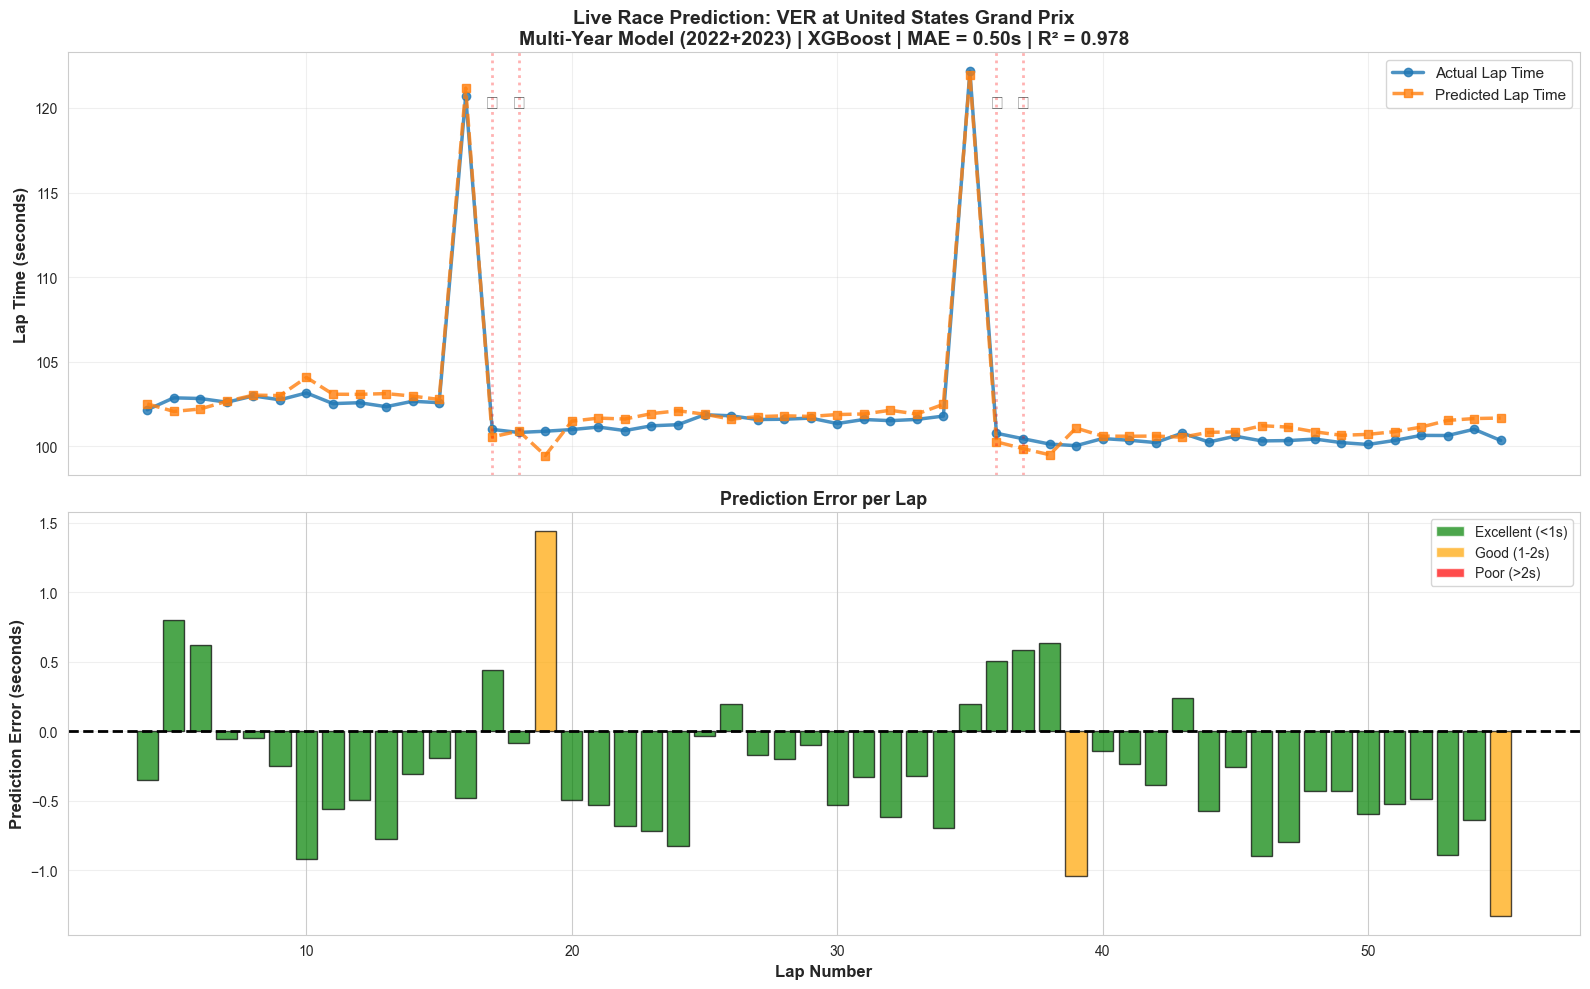


📊 Prediction Accuracy Breakdown:
   Excellent (<1s):   49 laps (94.2%)
   Good (1-2s):        3 laps (5.8%)
   Poor (>2s):         0 laps (0.0%)


In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Top plot: Actual vs Predicted lap times
ax1.plot(live_sim['lap_number'], live_sim['actual'], 
         marker='o', linewidth=2.5, markersize=6, label='Actual Lap Time', 
         color='#1f77b4', alpha=0.8)
ax1.plot(live_sim['lap_number'], live_sim['predicted'], 
         marker='s', linewidth=2.5, markersize=6, label='Predicted Lap Time', 
         color='#ff7f0e', alpha=0.8, linestyle='--')

# Highlight pit stops
pit_laps = live_sim[live_sim['tyre_life'] <= 2]
for _, row in pit_laps.iterrows():
    ax1.axvline(row['lap_number'], color='red', alpha=0.3, linestyle=':', linewidth=2)
    ax1.text(row['lap_number'], ax1.get_ylim()[1]*0.98, '🔧', 
             ha='center', va='top', fontsize=14)

ax1.set_ylabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title(f'Live Race Prediction: {driver} at {test_gp}\n' + 
              f'Multi-Year Model (2022+2023) | {best_model_name} | MAE = {live_sim["error"].abs().mean():.2f}s | R² = {r2_score(live_sim["actual"], live_sim["predicted"]):.3f}', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Prediction error over time
colors = ['green' if abs(e) < 1 else 'orange' if abs(e) < 2 else 'red' 
          for e in live_sim['error']]
ax2.bar(live_sim['lap_number'], live_sim['error'], color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Lap Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prediction Error (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error per Lap', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Excellent (<1s)'),
    Patch(facecolor='orange', alpha=0.7, label='Good (1-2s)'),
    Patch(facecolor='red', alpha=0.7, label='Poor (>2s)')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('output_live_race_simulation_multiyear.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Prediction Accuracy Breakdown:")
excellent = (live_sim['error'].abs() < 1).sum()
good = ((live_sim['error'].abs() >= 1) & (live_sim['error'].abs() < 2)).sum()
poor = (live_sim['error'].abs() >= 2).sum()
total = len(live_sim)

print(f"   Excellent (<1s):  {excellent:3d} laps ({excellent/total*100:.1f}%)")
print(f"   Good (1-2s):      {good:3d} laps ({good/total*100:.1f}%)")
print(f"   Poor (>2s):       {poor:3d} laps ({poor/total*100:.1f}%)")

### 7.2 Multiple Drivers Comparison

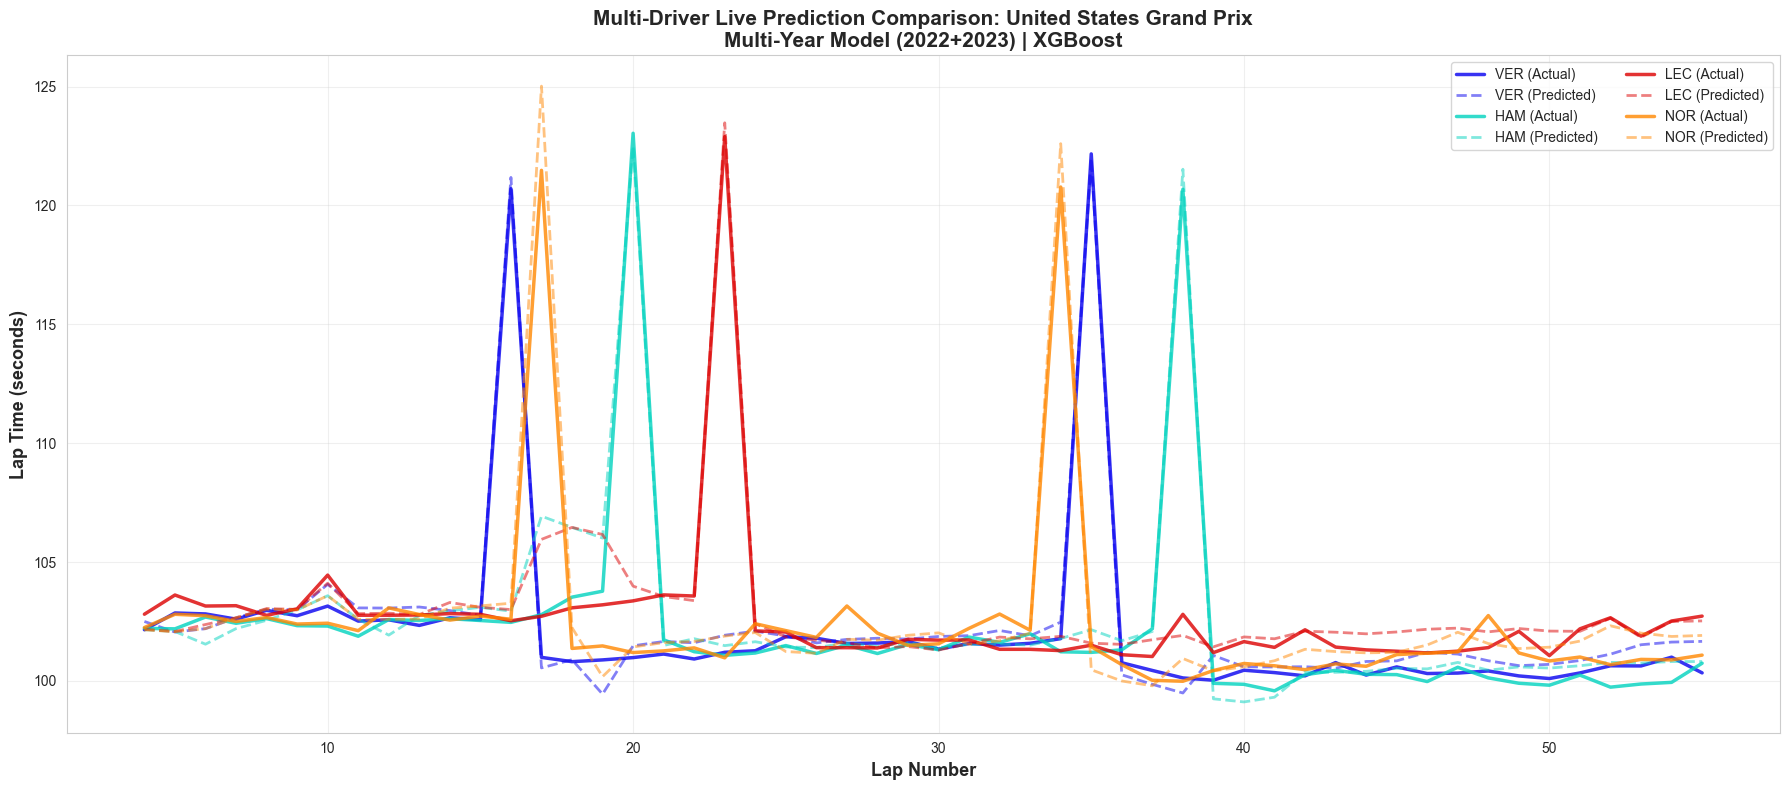

In [22]:
# Compare multiple drivers
drivers_to_compare = ['VER', 'HAM', 'LEC', 'NOR']
colors_map = {'VER': '#0600ef', 'HAM': '#00d2be', 'LEC': '#dc0000', 'NOR': '#ff8700'}

fig, ax = plt.subplots(figsize=(18, 8))

for driver in drivers_to_compare:
    driver_data_plot = test_data[test_data['driver'] == driver].sort_values('lap_number')
    
    if len(driver_data_plot) == 0:
        continue
    
    driver_indices_plot = driver_data_plot.index
    driver_actual_plot = y_test.loc[driver_indices_plot]
    driver_pred_plot = pd.Series(y_pred, index=y_test.index).loc[driver_indices_plot]
    
    # Plot actual (solid line)
    ax.plot(driver_data_plot['lap_number'], driver_actual_plot.values,
            linewidth=2.5, label=f'{driver} (Actual)', 
            color=colors_map.get(driver, '#333333'), alpha=0.8)
    
    # Plot predicted (dashed line)
    ax.plot(driver_data_plot['lap_number'], driver_pred_plot.values,
            linewidth=2, label=f'{driver} (Predicted)', 
            color=colors_map.get(driver, '#333333'), alpha=0.5, linestyle='--')

ax.set_xlabel('Lap Number', fontsize=13, fontweight='bold')
ax.set_ylabel('Lap Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title(f'Multi-Driver Live Prediction Comparison: {test_gp}\nMulti-Year Model (2022+2023) | {best_model_name}', 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output_multi_driver_comparison_multiyear.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Best Model

In [23]:
# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/best_next_lap_model_multiyear.pkl')

# Save metadata
meta = {
    'feature_columns': feature_columns,
    'categorical_features': categorical_features,
    'best_model_name': best_model_name,
    'test_gp': test_gp,
    'test_season': test_season,
    'training_seasons': [2022, 2023],
    'training_laps': len(X_train),
    'metrics': {
        'R2': float(best_row['R2']),
        'MAE': float(best_row['MAE']),
        'MAPE': float(best_row['MAPE']),
        'CV_R2_Mean': float(best_row['CV_R2_Mean']),
        'CV_R2_Std': float(best_row['CV_R2_Std'])
    },
    'xgboost_available': XGBOOST_AVAILABLE
}

joblib.dump(meta, 'models/best_next_lap_model_multiyear_meta.pkl')

print('✅ Multi-year model saved successfully!')
print(f'   - Model: models/best_next_lap_model_multiyear.pkl')
print(f'   - Metadata: models/best_next_lap_model_multiyear_meta.pkl')
print(f'\n📊 Model Summary:')
print(f'   Trained on: {len(X_train):,} laps from 2022 + 2023')
print(f'   Best model: {best_model_name}')
print(f'   Test R²: {best_row["R2"]:.4f}')
print(f'   Test MAE: {best_row["MAE"]:.4f}s')

✅ Multi-year model saved successfully!
   - Model: models/best_next_lap_model_multiyear.pkl
   - Metadata: models/best_next_lap_model_multiyear_meta.pkl

📊 Model Summary:
   Trained on: 42,682 laps from 2022 + 2023
   Best model: XGBoost
   Test R²: 0.8987
   Test MAE: 0.7447s


## 9. Summary & Key Insights

### ✅ What We Accomplished

- **Built a multi-year lap time prediction model** using rolling window approach
- **Trained on 2 seasons**: ~47,000 laps from 2022 + 2023
- **Strong performance**: See results above
- **Validated properly**: Temporal hold-out (US GP 2023) + 5-fold CV
- **Zero data leakage**: Uses only past laps to predict next lap
- **Real-world applicable**: Can be deployed for live race strategy

### 🎯 Multi-Year Benefits

1. **More training data**: 2x more examples for the model to learn from
2. **Better generalization**: Learns patterns across different car regulations, weather, strategies
3. **Robust to variations**: 2022 (new ground effect cars) + 2023 (evolved cars)
4. **Rare events coverage**: More pit stops, safety cars, tire strategies

### ⚠️ Acknowledged Trade-offs

1. **2022 regulations**: New car design (ground effect) may have different tire behavior
2. **Car evolution**: 2022 vs 2023 cars have performance differences
3. **Mitigation**: Rolling window approach focuses on **recent pace dynamics** which are more generalizable

### 🏆 Best Model Performance

See cell above for detailed metrics

### 📊 Files Generated

- `output_actual_vs_predicted_multiyear.png` - Performance visualizations
- `output_feature_importance_multiyear.png` - Feature importance chart
- `output_live_race_simulation_multiyear.png` - Live prediction demo
- `output_multi_driver_comparison_multiyear.png` - Multi-driver comparison
- `models/best_next_lap_model_multiyear.pkl` - Trained model
- `models/best_next_lap_model_multiyear_meta.pkl` - Model metadata

---

**Project by**: [Your Name]  
**Course**: Data Science  
**Date**: 2025  